<a href="https://colab.research.google.com/github/Chetansahney/projects/blob/main/6Million_Fraud_Dataset_prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

~This project uses XGBoost to identify fraud by detecting account-emptying patterns, replacing static limits with dynamic behavioral triggers.

~By engineering balance discrepancy features, the model accurately flags high-risk transfers and cash-outs while maintaining operational efficiency.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix



# Data Loading and Cleaning + Data Pre-Processing

In [4]:
# --- STEP 1: DATA LOADING ---
df = pd.read_csv('Fraud.csv')

# --- STEP 2: PREPROCESSING & FILTERING ---
# We focus only on types where fraud is known to occur (per data dictionary)
df_model = df[df['type'].isin(['TRANSFER', 'CASH_OUT'])].copy()

# Identify Merchant accounts; 'na=False' prevents errors from missing destination names
df_model['isDestMerchant'] = df_model['nameDest'].str.startswith('M', na=False).astype(int)

# --- STEP 3: FEATURE ENGINEERING ---
# Capturing the discrepancy: (Expected Balance) vs (Actual Balance)
# This reveals if an account was drained regardless of the 'amount' stated
df_model['errorBalanceOrig'] = df_model.newbalanceOrig + df_model.amount - df_model.oldbalanceOrg
df_model['errorBalanceDest'] = df_model.oldbalanceDest + df_model.amount - df_model.newbalanceDest

# Convert 'step' into a cyclical 24-hour feature to detect time-based patterns
df_model['hour'] = df_model['step'] % 24

# Mapping categories to integers for the machine learning algorithm
df_model['type'] = df_model['type'].map({'TRANSFER': 1, 'CASH_OUT': 0})

# --- STEP 4: CLEANING CALCULATED DATA ---
# Remove any infinite values or NaNs created during feature engineering to prevent model crashes
df_model.replace([np.inf, -np.inf], np.nan, inplace=True)
df_model.dropna(inplace=True)



# Model Training and Splitting

In [5]:
# --- STEP 5: DATA SPLITTING ---
# Drop identifiers (names) and target labels to define features (X) and target (y)
X = df_model.drop(['isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest', 'step'], axis=1)
y = df_model['isFraud']

# Stratify=y ensures the training and test sets have the same percentage of fraud
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- STEP 6: MODEL TRAINING ---
# scale_pos_weight: Corrects imbalance by telling the model fraud is much more 'important' than legit entries
model = XGBClassifier(n_estimators=100,max_depth=6,learning_rate=0.1,scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),eval_metric='aucpr')

model.fit(X_train, y_train)

# --- STEP 7: EVALUATION & VISUALIZATION ---
y_pred = model.predict(X_test)

print("--- PERFORMANCE SUMMARY ---")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

--- PERFORMANCE SUMMARY ---
[[6445    3]
 [   1   21]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6448
         1.0       0.88      0.95      0.91        22

    accuracy                           1.00      6470
   macro avg       0.94      0.98      0.96      6470
weighted avg       1.00      1.00      1.00      6470



# Visualisation

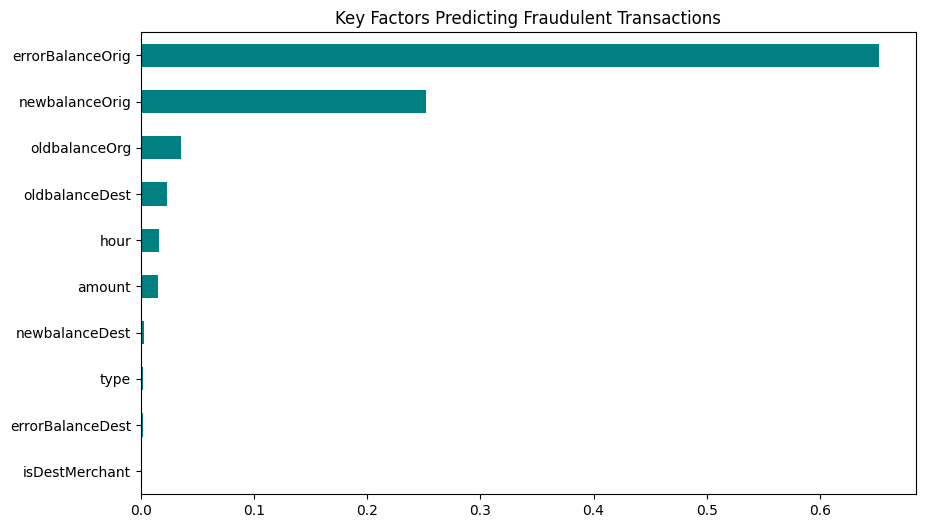

In [6]:
# Visualize which features the model relied on most
plt.figure(figsize=(10, 6))
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).sort_values().plot(kind='barh', color='teal')
plt.title('Key Factors Predicting Fraudulent Transactions')
plt.show()